In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")


 Using device: cuda


In [ ]:

# Load and preprocess dataset

df = pd.read_csv("Data CSVs/5g_backhaul_traffic_train-data.csv")
traffic = df['traffic_volume (Mbps)'].values

num_links = 39
time_steps = len(traffic) // num_links
traffic = traffic[:time_steps * num_links].reshape(time_steps, num_links)

# Normalize
mean, std = traffic.mean(), traffic.std()
traffic = (traffic - mean) / (std + 1e-6)

split = int(0.8 * time_steps)
train_data = torch.tensor(traffic[:split], dtype=torch.float32)
test_data = torch.tensor(traffic[split:], dtype=torch.float32)


In [ ]:

# Prepare sliding windows
def create_windows(data, window):
    X, Y = [], []
    for i in range(window, len(data)):
        X.append(data[i - window:i])
        Y.append(data[i])
    return torch.stack(X), torch.stack(Y)

window = 24
train_X, train_Y = create_windows(train_data, window)
test_X, test_Y = create_windows(test_data, window)

train_X, train_Y = train_X.to(device), train_Y.to(device)
test_X, test_Y = test_X.to(device), test_Y.to(device)
print(f"Train shape: {train_X.shape} | Test shape: {test_X.shape}")



In [ ]:
# Define LSTM model
class LSTMBackhaul(nn.Module):
    def __init__(self, num_nodes, hidden_dim, num_layers=2, dropout=0.2):
        super(LSTMBackhaul, self).__init__()
        self.lstm = nn.LSTM(
            input_size=num_nodes,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, num_nodes)

    def forward(self, x):
        # x: [batch, window, num_nodes]
        out, _ = self.lstm(x)
        out = out[:, -1, :]               # last timestep
        out = self.fc(out)
        return out.unsqueeze(-1)          # [batch, num_nodes, 1]



In [ ]:
# Initialize model
model = LSTMBackhaul(num_nodes=num_links, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
scaler = GradScaler()

batch_size = 64
epochs = 50
save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)
best_rmse = float('inf')



/tmp/ipykernel_23113/1314637779.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
# Training loop with checkpointing
train_losses, val_rmses = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    perm = torch.randperm(train_X.size(0))
    for i in range(0, train_X.size(0), batch_size):
        idx = perm[i:i + batch_size]
        x_batch, y_batch = train_X[idx], train_Y[idx].unsqueeze(-1)
        optimizer.zero_grad()
        with autocast():
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()

    # validation after each epoch
    model.eval()
    with torch.no_grad():
        preds = []
        for i in range(0, test_X.size(0), batch_size):
            pred = model(test_X[i:i + batch_size])
            preds.append(pred.squeeze().cpu())
        preds = torch.cat(preds)
        actuals = test_Y.cpu()
        rmse = torch.sqrt(((preds - actuals) ** 2).mean()).item()

    print(f"Epoch {epoch+1}/{epochs} | TrainLoss: {total_loss / len(train_X):.6f} | ValRMSE: {rmse:.4f}")

    train_losses.append(total_loss / len(train_X))
    val_rmses.append(rmse)

    # Save best model
    if rmse < best_rmse:
        best_rmse = rmse
        torch.save(model.state_dict(), f"{save_dir}/best_lstm_model.pth")
        print(f" Saved new best model with RMSE = {best_rmse:.4f}")



/tmp/ipykernel_23113/2465449495.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50 | TrainLoss: 0.003849 | ValRMSE: 0.1306
 Saved new best model with RMSE = 0.1306
Epoch 2/50 | TrainLoss: 0.000266 | ValRMSE: 0.1114
 Saved new best model with RMSE = 0.1114
Epoch 3/50 | TrainLoss: 0.000217 | ValRMSE: 0.1023
 Saved new best model with RMSE = 0.1023
Epoch 4/50 | TrainLoss: 0.000175 | ValRMSE: 0.0881
 Saved new best model with RMSE = 0.0881
Epoch 5/50 | TrainLoss: 0.000132 | ValRMSE: 0.0637
 Saved new best model with RMSE = 0.0637
Epoch 6/50 | TrainLoss: 0.000073 | ValRMSE: 0.0486
 Saved new best model with RMSE = 0.0486
Epoch 7/50 | TrainLoss: 0.000050 | ValRMSE: 0.0401
 Saved new best model with RMSE = 0.0401
Epoch 8/50 | TrainLoss: 0.000041 | ValRMSE: 0.0357
 Saved new best model with RMSE = 0.0357
Epoch 9/50 | TrainLoss: 0.000035 | ValRMSE: 0.0345
 Saved new best model with RMSE = 0.0345
Epoch 10/50 | TrainLoss: 0.000031 | ValRMSE: 0.0305
 Saved new best model with RMSE = 0.0305
Epoch 11/50 | TrainLoss: 0.000030 | ValRMSE: 0.0341
Epoch 12/50 | TrainLoss: 0.

In [ ]:
# Evaluation with detailed metrics
print("\n=== Evaluating best model ===")
model.load_state_dict(torch.load(f"{save_dir}/best_lstm_model.pth"))
model.eval()

with torch.no_grad():
    preds = []
    for i in range(0, test_X.size(0), batch_size):
        pred = model(test_X[i:i + batch_size])
        preds.append(pred.squeeze().cpu())
    preds = torch.cat(preds)
    actuals = test_Y.cpu()

preds_np, actuals_np = preds.numpy(), actuals.numpy()
preds_np = preds_np * std + mean
actuals_np = actuals_np * std + mean

rmse = np.sqrt(mean_squared_error(actuals_np, preds_np))
mae = mean_absolute_error(actuals_np, preds_np)
mape = np.mean(np.abs((actuals_np - preds_np) / (actuals_np + 1e-6))) * 100
r2 = r2_score(actuals_np, preds_np)

print(f"\n Final Test Metrics:")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")




=== Evaluating best model ===

 Final Test Metrics:
RMSE : 26.2040
MAE  : 19.2914
MAPE : 2.00%
R²   : 0.9958


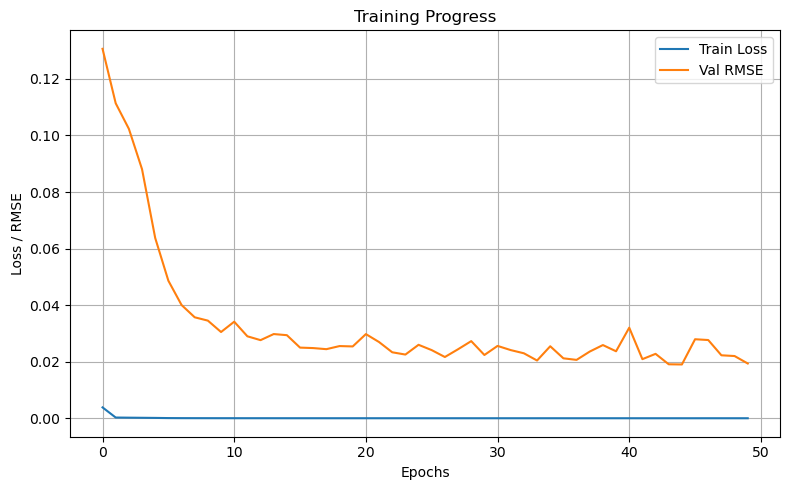

In [ ]:
#  Plot training curves

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_rmses, label="Val RMSE")
plt.xlabel("Epochs")
plt.ylabel("Loss / RMSE")
plt.title("Training Progress")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
# Generate Predictions for Entire Dataset
print("Generating predictions for entire dataset...")

# Combine train and test data for full predictions
# full_data = torch.cat([train_data, test_data], dim=0).to(device)
full_data = torch.tensor(traffic, dtype=torch.float32).to(device)
full_X, full_Y = create_windows(full_data, window)
full_X = full_X.to(device)
full_Y = full_Y.to(device)

# Generate predictions in batches
model.eval()
all_predictions = []
all_actuals = []

with torch.no_grad():
    for i in range(0, len(full_X), batch_size):
        batch_X = full_X[i:i+batch_size]
        batch_Y = full_Y[i:i+batch_size]
        
        with autocast():
            preds = model(batch_X).squeeze(-1)
        
        all_predictions.append(preds.cpu())
        all_actuals.append(batch_Y.cpu())

# Concatenate all batches
all_predictions = torch.cat(all_predictions, dim=0).numpy()
all_actuals = torch.cat(all_actuals, dim=0).numpy()

# Denormalize predictions and actuals
all_predictions_denorm = all_predictions * std + mean
all_actuals_denorm = all_actuals * std + mean

print(f" Predictions generated for {len(all_predictions)} time steps")
print(f"   Shape: {all_predictions_denorm.shape}")
print(f"   Time steps: {all_predictions_denorm.shape[0]}")
print(f"   Links: {all_predictions_denorm.shape[1]}")

In [ ]:
#  Calculate Comprehensive Metrics
from sklearn.metrics import mean_absolute_percentage_error

# Overall metrics
overall_rmse = np.sqrt(mean_squared_error(all_actuals_denorm.flatten(), all_predictions_denorm.flatten()))
overall_mae = mean_absolute_error(all_actuals_denorm.flatten(), all_predictions_denorm.flatten())
overall_mape = mean_absolute_percentage_error(all_actuals_denorm.flatten(), all_predictions_denorm.flatten()) * 100
overall_r2 = r2_score(all_actuals_denorm.flatten(), all_predictions_denorm.flatten())

print("="*60)
print(" OVERALL PREDICTION METRICS")
print("="*60)
print(f"RMSE:  {overall_rmse:.4f} Mbps")
print(f"MAE:   {overall_mae:.4f} Mbps")
print(f"MAPE:  {overall_mape:.2f}%")
print(f"R²:    {overall_r2:.4f}")
print("="*60)

# Per-link metrics
print("\n📡 PER-LINK METRICS (Top 10 by RMSE)")
print("="*60)
link_metrics = []
for link_idx in range(num_links):
    link_actual = all_actuals_denorm[:, link_idx]
    link_pred = all_predictions_denorm[:, link_idx]
    
    link_rmse = np.sqrt(mean_squared_error(link_actual, link_pred))
    link_mae = mean_absolute_error(link_actual, link_pred)
    link_mape = mean_absolute_percentage_error(link_actual, link_pred) * 100
    link_r2 = r2_score(link_actual, link_pred)
    
    link_metrics.append({
        'link_id': link_idx,
        'rmse': link_rmse,
        'mae': link_mae,
        'mape': link_mape,
        'r2': link_r2
    })

link_metrics_df = pd.DataFrame(link_metrics)
link_metrics_df = link_metrics_df.sort_values('rmse', ascending=False)

print(link_metrics_df.head(10).to_string(index=False))
print("="*60)

📊 OVERALL PREDICTION METRICS
RMSE:  26.5571 Mbps
MAE:   19.5402 Mbps
MAPE:  1.91%
R²:    0.9996

📡 PER-LINK METRICS (Top 10 by RMSE)
 link_id      rmse       mae     mape       r2
      37 53.547403 43.020375 0.800872 0.998735
      38 39.295811 31.569535 0.788924 0.998777
      36 39.116649 31.036685 0.774134 0.998796
      16 34.880374 26.467272 1.600424 0.998751
      20 34.672471 26.203762 1.578120 0.998772
       0 34.072515 25.794327 1.550444 0.998814
       4 33.846476 25.728679 1.565248 0.998828
      12 33.820059 25.898123 1.609834 0.998832
       8 32.932189 25.146261 1.546849 0.998889
      30 31.163835 24.923865 1.226410 0.999121


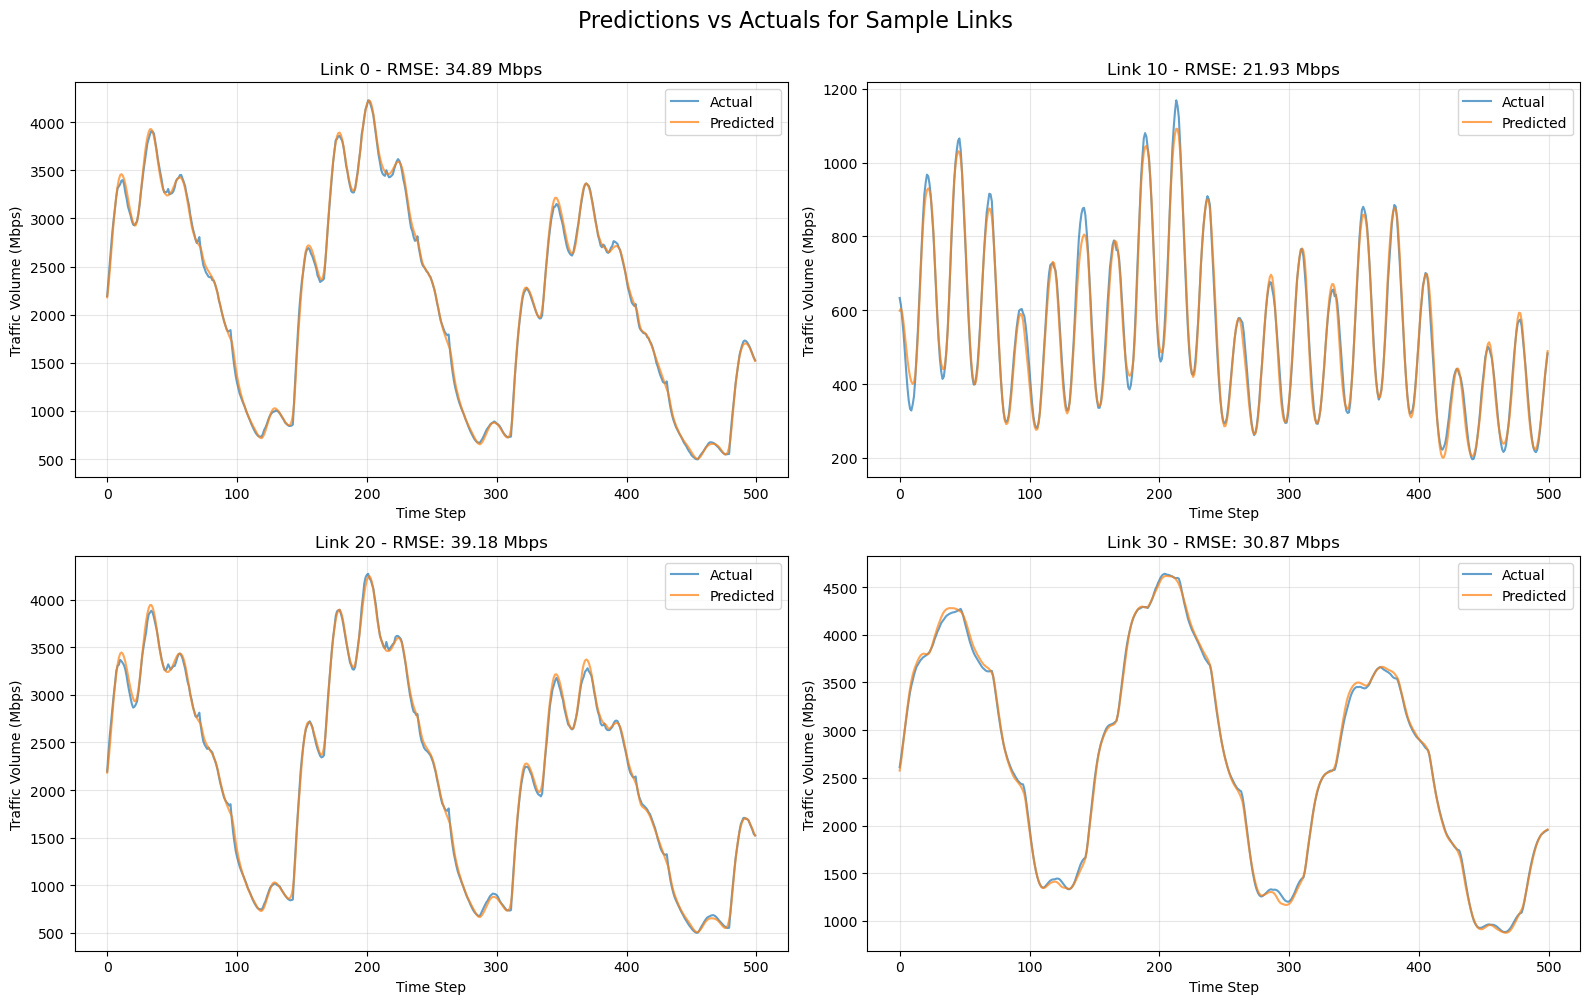

In [ ]:
#  Visualize Predictions vs Actuals

# Select sample links for visualization
sample_links = [0, 10, 20, 30]  # 4 different links
sample_range = slice(0, 500)    # First 500 time steps

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, link_id in enumerate(sample_links):
    ax = axes[idx]
    
    time_idx = np.arange(len(all_actuals_denorm[sample_range, link_id]))
    actual = all_actuals_denorm[sample_range, link_id]
    predicted = all_predictions_denorm[sample_range, link_id]
    
    ax.plot(time_idx, actual, label='Actual', alpha=0.7, linewidth=1.5)
    ax.plot(time_idx, predicted, label='Predicted', alpha=0.7, linewidth=1.5)
    
    link_rmse = np.sqrt(mean_squared_error(actual, predicted))
    ax.set_title(f"Link {link_id} - RMSE: {link_rmse:.2f} Mbps")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Traffic Volume (Mbps)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("Predictions vs Actuals for Sample Links", fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

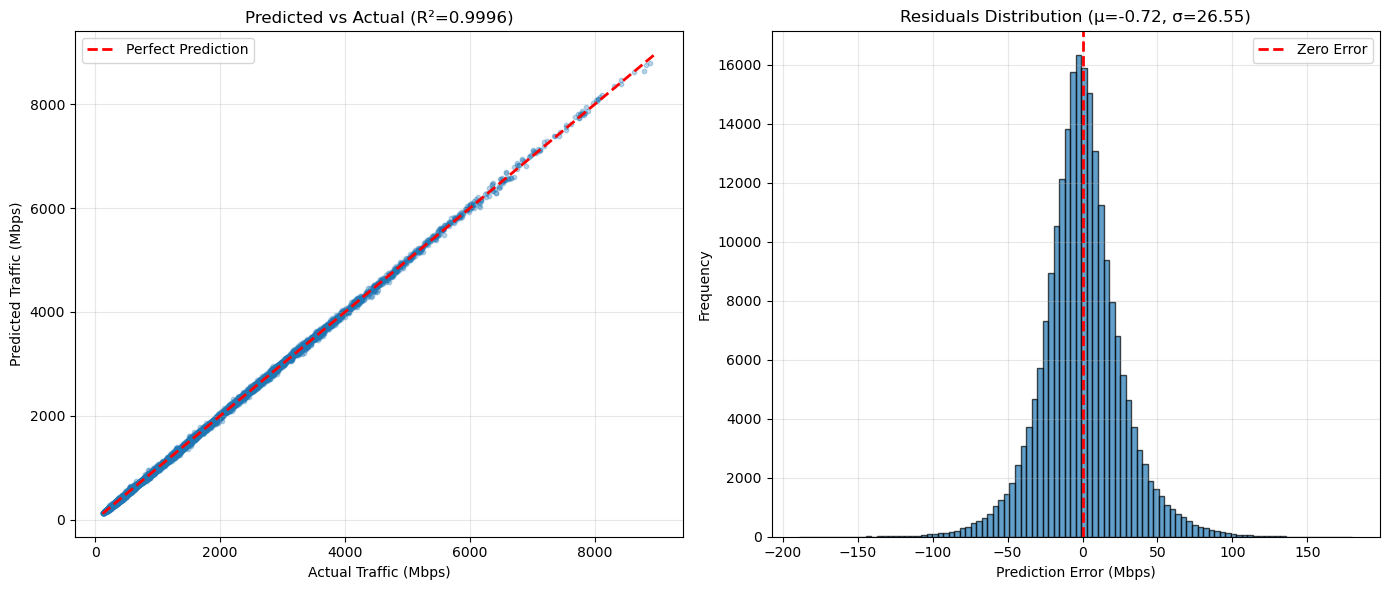

In [ ]:
#  Scatter Plot: Predicted vs Actual

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# All data points
ax1 = axes[0]
sample_points = np.random.choice(len(all_actuals_denorm.flatten()), size=10000, replace=False)
ax1.scatter(all_actuals_denorm.flatten()[sample_points], 
           all_predictions_denorm.flatten()[sample_points], 
           alpha=0.3, s=10)
ax1.plot([all_actuals_denorm.min(), all_actuals_denorm.max()], 
        [all_actuals_denorm.min(), all_actuals_denorm.max()], 
        'r--', label='Perfect Prediction', linewidth=2)
ax1.set_xlabel("Actual Traffic (Mbps)")
ax1.set_ylabel("Predicted Traffic (Mbps)")
ax1.set_title(f"Predicted vs Actual (R²={overall_r2:.4f})")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Residuals distribution
ax2 = axes[1]
residuals = (all_predictions_denorm - all_actuals_denorm).flatten()
ax2.hist(residuals, bins=100, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
ax2.set_xlabel("Prediction Error (Mbps)")
ax2.set_ylabel("Frequency")
ax2.set_title(f"Residuals Distribution (μ={residuals.mean():.2f}, σ={residuals.std():.2f})")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
#  Save Predictions to CSV

print("Creating predictions in original dataset format...")

# Load original dataset to get timestamps and structure
original_df = pd.read_csv('/home/vedant/CN/project/5g_backhaul_traffic_improved.csv')

# Define link capacities (from dataset_generation.py)
link_capacities = {
    **{f'link_{i}': 5000 for i in range(1, 25)},    # Access links: 5 Gbps
    **{f'link_{i}': 10000 for i in range(25, 37)},  # Aggregation links: 10 Gbps
    **{f'link_{i}': 50000 for i in range(37, 40)}   # Core links: 50 Gbps
}

def calculate_packet_count(traffic_volume_mbps):
    """Convert traffic volume (Mbps) to packet count per hour"""
    avg_packet_size_bytes = 800
    packets_per_second = (traffic_volume_mbps * 1_000_000) / (avg_packet_size_bytes * 8)
    packets_per_hour = packets_per_second * 3600
    variation = np.random.normal(1, 0.1)
    return int(max(1, packets_per_hour * variation))

# Create prediction records matching original format
prediction_records = []

# Step 1: Add the first 'window' timesteps using actual data (no predictions yet)
print(f"Adding first {window} timesteps (used as input window)...")
for t in range(window):
    # Get timestamp info for each link at this time step
    for link_idx in range(num_links):
        link_id = f'link_{link_idx + 1}'
        # Get the actual row from original dataset
        row_data = original_df[(original_df['link_id'] == link_id)].iloc[t]
        
        prediction_records.append({
            'timestamp': row_data['timestamp'],
            'day_of_week': row_data['day_of_week'],
            'link_id': link_id,
            'traffic_volume (Mbps)': row_data['traffic_volume (Mbps)'],
            'packet_count (packets/hour)': row_data['packet_count (packets/hour)'],
            'bandwidth_utilization (ratio)': row_data['bandwidth_utilization (ratio)']
        })

# Step 2: Add predictions for remaining timesteps
print(f"Adding {len(all_predictions_denorm)} predicted timesteps...")
start_idx = window  # First prediction corresponds to this timestamp index in the dataset

for t in range(len(all_predictions_denorm)):
    # Get corresponding timestamp from original data
    timestamp_idx = start_idx + t
    
    # Get timestamp info (assuming 39 links per timestamp)
    if timestamp_idx < len(original_df) // num_links:
        sample_row = original_df[original_df['link_id'] == 'link_1'].iloc[timestamp_idx]
        timestamp = sample_row['timestamp']
        day_of_week = sample_row['day_of_week']
        
        for link_idx in range(num_links):
            link_id = f'link_{link_idx + 1}'
            predicted_traffic = all_predictions_denorm[t, link_idx]
            
            # Calculate packet count
            packet_count = calculate_packet_count(predicted_traffic)
            
            # Calculate bandwidth utilization
            link_capacity = link_capacities[link_id]
            bandwidth_utilization = min(1.0, predicted_traffic / link_capacity)
            
            prediction_records.append({
                'timestamp': timestamp,
                'day_of_week': day_of_week,
                'link_id': link_id,
                'traffic_volume (Mbps)': max(10, predicted_traffic),
                'packet_count (packets/hour)': packet_count,
                'bandwidth_utilization (ratio)': bandwidth_utilization
            })

predictions_df = pd.DataFrame(prediction_records)

# Save to CSV
output_path = '/home/vedant/CN/project/predictions_final.csv'
predictions_df.to_csv(output_path, index=False)

print(f"\n Predictions saved to: {output_path}")
print(f"   Total records: {len(predictions_df):,}")
print(f"   Expected records: {len(original_df):,}")
print(f"   Match: {' YES' if len(predictions_df) == len(original_df) else '❌ NO'}")
print(f"   Difference: {len(original_df) - len(predictions_df):,} records")
print(f"   Columns: {list(predictions_df.columns)}")

# Display sample
print("\n Sample Predictions (matching original format):")
print(predictions_df.head(20).to_string(index=False))

In [ ]:
#  Comparison Analysis: Actual vs Predicted

print("Creating comparison analysis...")

# Create comparison dataframe
comparison_records = []

for t in range(len(all_predictions_denorm)):
    timestamp_idx = window + 1 + t
    
    if timestamp_idx < len(original_df) // num_links:
        sample_row = original_df[original_df['link_id'] == 'link_1'].iloc[timestamp_idx]
        timestamp = sample_row['timestamp']
        
        for link_idx in range(num_links):
            link_id = f'link_{link_idx + 1}'
            actual = all_actuals_denorm[t, link_idx]
            predicted = all_predictions_denorm[t, link_idx]
            
            comparison_records.append({
                'timestamp': timestamp,
                'link_id': link_id,
                'actual_traffic_mbps': actual,
                'predicted_traffic_mbps': predicted,
                'error_mbps': predicted - actual,
                'absolute_error_mbps': np.abs(predicted - actual),
                'percentage_error': np.abs((predicted - actual) / (actual + 1e-6)) * 100
            })

comparison_df = pd.DataFrame(comparison_records)

# Save comparison
comparison_path = '/home/vedant/CN/project/predictions_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f" Comparison analysis saved to: {comparison_path}")
print(f"   Total records: {len(comparison_df):,}")

# Link-wise summary
link_summary = comparison_df.groupby('link_id').agg({
    'actual_traffic_mbps': ['mean', 'std', 'min', 'max'],
    'predicted_traffic_mbps': ['mean', 'std', 'min', 'max'],
    'absolute_error_mbps': ['mean', 'std', 'max'],
    'percentage_error': ['mean', 'std', 'max']
}).round(2)

link_summary.columns = ['_'.join(col).strip() for col in link_summary.columns.values]
link_summary = link_summary.reset_index()

# Save link summary
summary_path = '/home/vedant/CN/project/predictions_summary_by_link.csv'
link_summary.to_csv(summary_path, index=False)
print(f" Link summary saved to: {summary_path}")

print("\n Link-wise Performance Summary:")
print(link_summary.to_string(index=False))

In [ ]:
#  Add temporal features and verify format

print("Adding temporal features to match original dataset format...")

# Add hour_of_day if needed for analysis (optional)
predictions_df['hour_of_day'] = pd.to_datetime(predictions_df['timestamp']).dt.hour

# Verify format matches original
print("\n Format Verification:")
print(f"Original dataset columns: {list(original_df.columns)}")
print(f"Predictions dataset columns: {list(predictions_df.columns)}")

# Compare sample statistics
print("\n Statistics Comparison:")
print(f"\nOriginal Dataset:")
print(f"  Mean traffic: {original_df['traffic_volume (Mbps)'].mean():.2f} Mbps")
print(f"  Mean utilization: {original_df['bandwidth_utilization (ratio)'].mean():.4f}")
print(f"  Total records: {len(original_df):,}")

print(f"\nPredictions Dataset:")
print(f"  Mean traffic: {predictions_df['traffic_volume (Mbps)'].mean():.2f} Mbps")
print(f"  Mean utilization: {predictions_df['bandwidth_utilization (ratio)'].mean():.4f}")
print(f"  Total records: {len(predictions_df):,}")

print("\n Sample comparison:")
print(predictions_df[['timestamp', 'link_id', 'traffic_volume (Mbps)', 'bandwidth_utilization (ratio)']].head(10))

Adding temporal features to match original dataset format...

✅ Format Verification:
Original dataset columns: ['timestamp', 'day_of_week', 'link_id', 'traffic_volume (Mbps)', 'packet_count (packets/hour)', 'bandwidth_utilization (ratio)']
Predictions dataset columns: ['timestamp', 'day_of_week', 'link_id', 'traffic_volume (Mbps)', 'packet_count (packets/hour)', 'bandwidth_utilization (ratio)', 'hour_of_day']

📊 Statistics Comparison:

Original Dataset:
  Mean traffic: 1665.30 Mbps
  Mean utilization: 0.2035
  Total records: 224,640

Predictions Dataset:
  Mean traffic: 1664.58 Mbps
  Mean utilization: 0.2034
  Total records: 224,640

📈 Sample comparison:
             timestamp  link_id  traffic_volume (Mbps)  \
0  2024-01-01 00:00:00   link_1             310.442897   
1  2024-01-01 00:00:00   link_2             206.961932   
2  2024-01-01 00:00:00   link_3              64.366936   
3  2024-01-01 00:00:00   link_4              42.911290   
4  2024-01-01 00:00:00   link_5             32

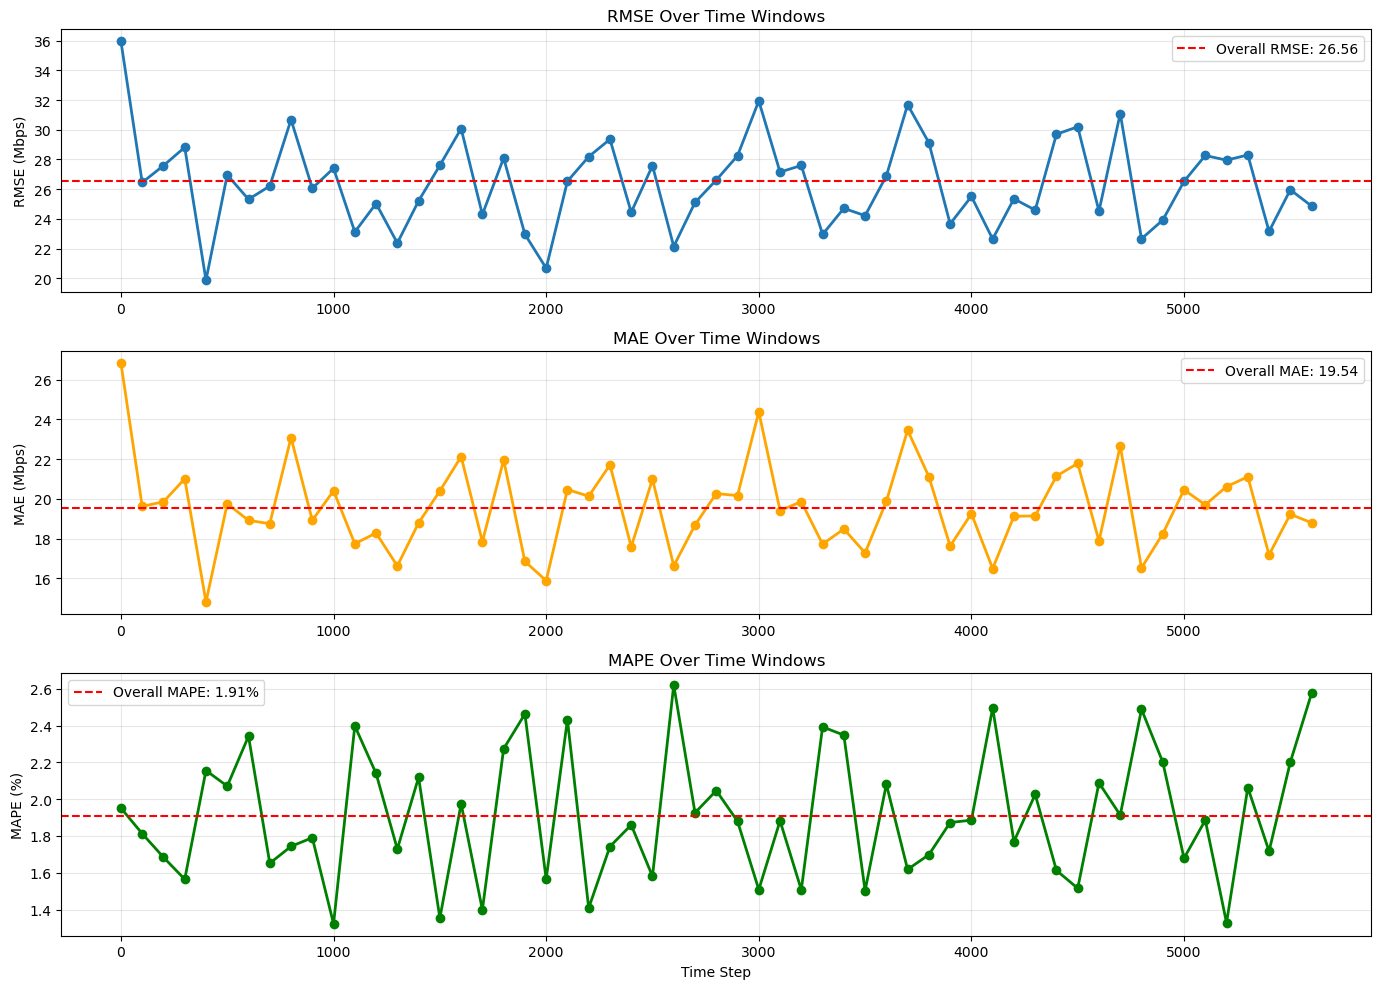


📈 Error Stability Analysis:
   RMSE: μ=26.39, σ=2.99
   MAE:  μ=19.54, σ=2.18
   MAPE: μ=1.91%, σ=0.34%


In [ ]:
#  Error Analysis Over Time

# Calculate error metrics over time windows
window_size = 100
time_windows = range(0, len(all_predictions_denorm) - window_size, window_size)

window_rmse = []
window_mae = []
window_mape = []

for start in time_windows:
    end = start + window_size
    window_actual = all_actuals_denorm[start:end].flatten()
    window_pred = all_predictions_denorm[start:end].flatten()
    
    window_rmse.append(np.sqrt(mean_squared_error(window_actual, window_pred)))
    window_mae.append(mean_absolute_error(window_actual, window_pred))
    window_mape.append(mean_absolute_percentage_error(window_actual, window_pred) * 100)

# Plot error metrics over time
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(list(time_windows), window_rmse, marker='o', linewidth=2)
axes[0].set_ylabel("RMSE (Mbps)")
axes[0].set_title("RMSE Over Time Windows")
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=overall_rmse, color='r', linestyle='--', label=f'Overall RMSE: {overall_rmse:.2f}')
axes[0].legend()

axes[1].plot(list(time_windows), window_mae, marker='o', color='orange', linewidth=2)
axes[1].set_ylabel("MAE (Mbps)")
axes[1].set_title("MAE Over Time Windows")
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=overall_mae, color='r', linestyle='--', label=f'Overall MAE: {overall_mae:.2f}')
axes[1].legend()

axes[2].plot(list(time_windows), window_mape, marker='o', color='green', linewidth=2)
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("MAPE (%)")
axes[2].set_title("MAPE Over Time Windows")
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=overall_mape, color='r', linestyle='--', label=f'Overall MAPE: {overall_mape:.2f}%')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\n Error Stability Analysis:")
print(f"   RMSE: μ={np.mean(window_rmse):.2f}, σ={np.std(window_rmse):.2f}")
print(f"   MAE:  μ={np.mean(window_mae):.2f}, σ={np.std(window_mae):.2f}")
print(f"   MAPE: μ={np.mean(window_mape):.2f}%, σ={np.std(window_mape):.2f}%")

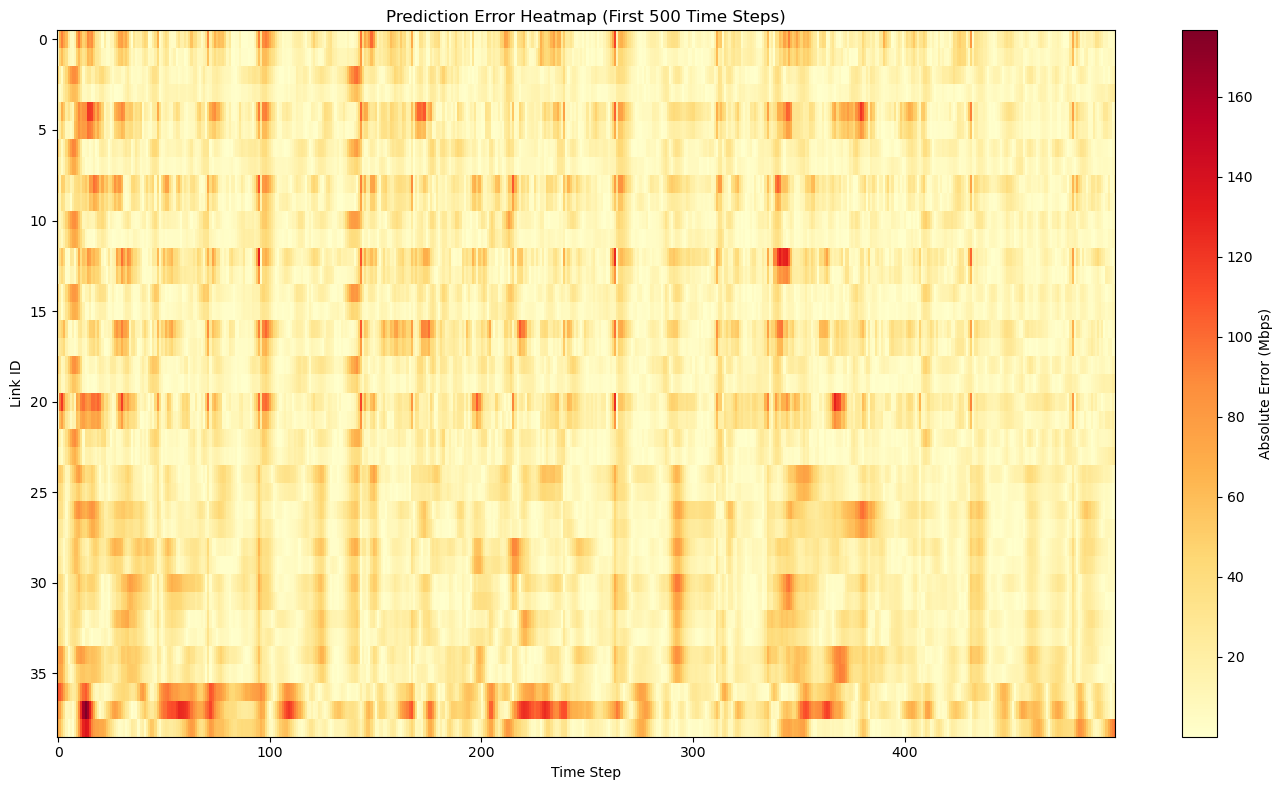


⚠️  Top 10 Most Challenging Time Steps:
   1. Time Step 10: Avg Error = 56.51 Mbps
   2. Time Step 9: Avg Error = 54.44 Mbps
   3. Time Step 95: Avg Error = 52.55 Mbps
   4. Time Step 263: Avg Error = 49.66 Mbps
   5. Time Step 11: Avg Error = 48.29 Mbps
   6. Time Step 97: Avg Error = 47.30 Mbps
   7. Time Step 98: Avg Error = 47.03 Mbps
   8. Time Step 15: Avg Error = 46.13 Mbps
   9. Time Step 8: Avg Error = 45.48 Mbps
   10. Time Step 14: Avg Error = 44.39 Mbps

⚠️  Top 10 Most Challenging Links:
   1. Link 37: Avg Error = 48.62 Mbps
   2. Link 36: Avg Error = 34.07 Mbps
   3. Link 20: Avg Error = 29.66 Mbps
   4. Link 4: Avg Error = 29.37 Mbps
   5. Link 38: Avg Error = 28.58 Mbps
   6. Link 16: Avg Error = 27.92 Mbps
   7. Link 8: Avg Error = 26.93 Mbps
   8. Link 12: Avg Error = 26.72 Mbps
   9. Link 0: Avg Error = 26.46 Mbps
   10. Link 34: Avg Error = 26.07 Mbps


In [ ]:
#  Heatmap: Prediction Error by Link and Time

# Create error matrix (time x links)
n_time_samples = min(500, len(all_predictions_denorm))  # Limit for visualization
error_matrix = np.abs(all_predictions_denorm[:n_time_samples] - all_actuals_denorm[:n_time_samples])

plt.figure(figsize=(14, 8))
im = plt.imshow(error_matrix.T, aspect='auto', cmap='YlOrRd', interpolation='nearest')
plt.colorbar(im, label='Absolute Error (Mbps)')
plt.xlabel("Time Step")
plt.ylabel("Link ID")
plt.title(f"Prediction Error Heatmap (First {n_time_samples} Time Steps)")
plt.tight_layout()
plt.show()

# Find worst performing time periods and links
worst_times = np.argsort(error_matrix.mean(axis=1))[-10:]
worst_links = np.argsort(error_matrix.mean(axis=0))[-10:]

print(f"\n  Top 10 Most Challenging Time Steps:")
for idx, t in enumerate(worst_times[::-1], 1):
    print(f"   {idx}. Time Step {t}: Avg Error = {error_matrix[t].mean():.2f} Mbps")

print(f"\n  Top 10 Most Challenging Links:")
for idx, link in enumerate(worst_links[::-1], 1):
    print(f"   {idx}. Link {link}: Avg Error = {error_matrix[:, link].mean():.2f} Mbps")